In [30]:
# 3. Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

Wir laden nochmals den MNIST-Datensatz und betrachten genau die Array-Shapes, welche wir auch beim geladenen NOTMNIST-Datensatz erhalten müssen:

In [169]:
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 5. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train.dtype,y_train.dtype,(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(dtype('float32'),
 dtype('uint8'),
 ((60000, 28, 28, 1), (60000,)),
 ((10000, 28, 28, 1), (10000,)))

In [170]:
np.min(X_train),np.max(X_train)

(0.0, 1.0)

import pandas as pd
#ev. ist es nötig, die folgenden Befehle auszuführen:

    !unzip train.csv.zip
    !unzip test.csv.zip
    !chmod 644 test.csv
    !chmod 644 train.csv
    !chmod 644 test.csv

In [178]:
from sklearn.preprocessing import OneHotEncoder
df_train= pd.read_csv('train.csv',header=None,index_col=0)
X = df_train.values[:,1:]
y = df_train.values[:,0]
X = X.reshape(-1,28,28,1)
X = X.astype('float32')
X /= 255
X.dtype,X.shape,np.min(X),np.max(X),y.shape

(dtype('float32'), (9360, 28, 28, 1), 0.0, 1.0, (9360,))

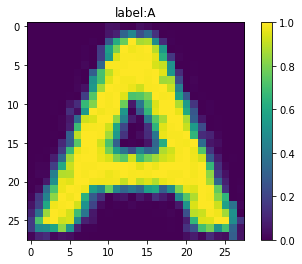

In [179]:
plt.imshow(X[0].reshape(28,28))
plt.title('label:{0}'.format(y[0]))
plt.colorbar();

(9360,)

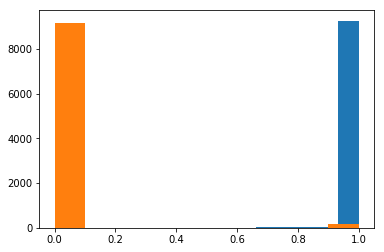

In [180]:
max_vals = np.max(X.reshape(-1,28*28),axis=1)
min_vals = np.min(X.reshape(-1,28*28),axis=1)
plt.hist(max_vals);
plt.hist(min_vals);
max_vals.shape

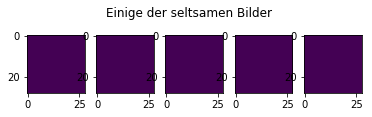

In [181]:
X_sel = X[min_vals>0.5,:,:,0]

NrImages = 5
for i in range(X_sel.shape[0]):
    if i>=NrImages: break
    plt.subplot(1,NrImages,i+1)
    plt.imshow(X_sel[i,:,:])
plt.suptitle('Einige der seltsamen Bilder',y=0.7);

In [182]:
X.shape,y.shape

((9360, 28, 28, 1), (9360,))

In [183]:
#Entferne die leeren Bilder!
X = X[min_vals<0.5,:,:,:]
y = y[min_vals<0.5]
y = pd.Series(y,name='target')

In [184]:
X.shape,y.shape

((9185, 28, 28, 1), (9185,))

In [185]:
df_test= pd.read_csv('test.csv',header=None,index_col=0)
X_test = df_test.values
X_test = X_test.reshape(-1,28,28,1)
X_test = X_test.astype('float32')
X_test /= 255
X_test.dtype,X_test.shape,np.min(X_test),np.max(X_test)

(dtype('float32'), (9364, 28, 28, 1), 0.0, 1.0)

In [186]:
label_to_int_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9}

In [187]:
y_int = y.map(label_to_int_dict)
#Äquivalent, aber weniger transparent:
#pd.Series(y_NotMNIST.unique()).map(ord)-65

y_int = y_int.values.reshape(-1,1).astype('uint8')
y_int.dtype,y_int.shape,np.unique(y_int)

(dtype('uint8'), (9185, 1), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [188]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto')

y_ohe = ohe.fit_transform(y_int)

#nicht sehr speichereffizient, aber wir haben ja auch nur wenig Daten...
y_ohe = y_ohe.todense().astype('uint8')
print(y_ohe.shape)
y_int[0],y_ohe[0,:]

(9185, 10)


(array([0], dtype=uint8),
 matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8))

In [189]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y_ohe,test_size=0.2,random_state=42)
X_train.shape,y_val.shape

((7348, 28, 28, 1), (1837, 10))

In [198]:
# 7. Define model architecture
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1),name='myconv1'))
model.add(Convolution2D(32, (3, 3), activation='relu',name='myconv2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu',name='mydense1'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax',name='mydense2'))

In [199]:
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Hier lohnt es sich ev., kurz mit der batch_size zu spielen. Bei mir bspw dauert eine Epoche ~13s für eine batch_size von 32, für eine batch_size von 512 jedoch nur ~3s.

In [200]:
# 9. Fit model on training data
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512, epochs=10, verbose=1)

Train on 7348 samples, validate on 1837 samples
Epoch 1/10
7348/7348 [==============================] - 5s 697us/step - loss: 1.4509 - acc: 0.5216 - val_loss: 0.6325 - val_acc: 0.8498
Epoch 2/10
7348/7348 [==============================] - 3s 374us/step - loss: 0.6750 - acc: 0.8048 - val_loss: 0.4961 - val_acc: 0.8639
Epoch 3/10
7348/7348 [==============================] - 3s 373us/step - loss: 0.5174 - acc: 0.8537 - val_loss: 0.4067 - val_acc: 0.8792
Epoch 4/10
7348/7348 [==============================] - 3s 369us/step - loss: 0.4305 - acc: 0.8772 - val_loss: 0.3666 - val_acc: 0.8884
Epoch 5/10
7348/7348 [==============================] - 3s 378us/step - loss: 0.3694 - acc: 0.8895 - val_loss: 0.3219 - val_acc: 0.9091
Epoch 6/10
7348/7348 [==============================] - 3s 374us/step - loss: 0.3275 - acc: 0.9031 - val_loss: 0.3031 - val_acc: 0.9113
Epoch 7/10
7348/7348 [==============================] - 3s 379us/step - loss: 0.2925 - acc: 0.9128 - val_loss: 0.2882 - val_acc: 0.9145


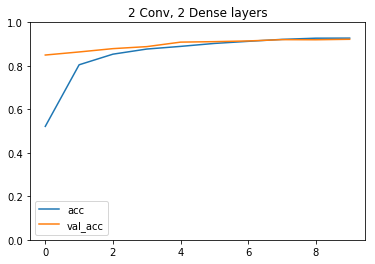

In [201]:
plt.plot(hist.history['acc'],label='acc')
plt.plot(hist.history['val_acc'],label='val_acc')
plt.ylim(0,1)
plt.title('2 Conv, 2 Dense layers, after 10 Epochs')
plt.legend()

In [202]:
#noch etwas weitertrainieren könnte helfen?
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512, epochs=30, verbose=1)

Train on 7348 samples, validate on 1837 samples
Epoch 1/30
7348/7348 [==============================] - 3s 377us/step - loss: 0.2131 - acc: 0.9341 - val_loss: 0.2572 - val_acc: 0.9227
Epoch 2/30
7348/7348 [==============================] - 3s 364us/step - loss: 0.1959 - acc: 0.9373 - val_loss: 0.2526 - val_acc: 0.9260
Epoch 3/30
7348/7348 [==============================] - 3s 358us/step - loss: 0.1879 - acc: 0.9407 - val_loss: 0.2549 - val_acc: 0.9260
Epoch 4/30
7348/7348 [==============================] - 3s 372us/step - loss: 0.1671 - acc: 0.9476 - val_loss: 0.2518 - val_acc: 0.9292
Epoch 5/30
7348/7348 [==============================] - 3s 375us/step - loss: 0.1644 - acc: 0.9471 - val_loss: 0.2524 - val_acc: 0.9292
Epoch 6/30
7348/7348 [==============================] - 3s 381us/step - loss: 0.1552 - acc: 0.9498 - val_loss: 0.2607 - val_acc: 0.9260
Epoch 7/30
7348/7348 [==============================] - 3s 367us/step - loss: 0.1407 - acc: 0.9526 - val_loss: 0.2656 - val_acc: 0.9238


In [224]:
# 10. Evaluate model on validation data
score = model.evaluate(X_val, y_val, verbose=0)
print(model.metrics_names)
np.around(score,2)

['loss', 'acc']


array([0.32, 0.93])

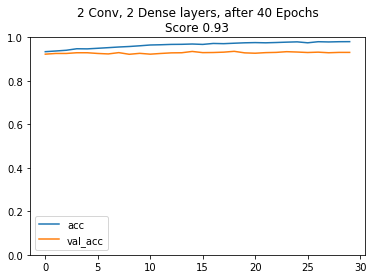

In [225]:
plt.plot(hist.history['acc'],label='acc')
plt.plot(hist.history['val_acc'],label='val_acc')
plt.ylim(0,1)
plt.title('2 Conv, 2 Dense layers, after 40 Epochs\Validation Score {0:1.2f}'.format(score[1]))
plt.legend()

Versuchen wir es nun mit einer etwas tieferen Architektur!

In [205]:
# 7. Define model architecture
model2 = Sequential()
model2.add(Convolution2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1),name='myconv1_1'))
model2.add(Convolution2D(32, (3, 3), activation='relu',name='myconv1_2'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Convolution2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1),name='myconv2_1'))
model2.add(Convolution2D(32, (3, 3), activation='relu',name='myconv2_2'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
 
model2.add(Flatten())
model2.add(Dense(128, activation='relu',name='mydense1'))
model2.add(Dense(128, activation='relu',name='mydense2'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

# 8. Compile model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [208]:
# 9. Fit model on training data
NrEpochs2 = 20
hist2 = model2.fit(X_train, y_train, 
          batch_size=128, epochs=NrEpochs2, validation_data=(X_val, y_val),verbose=1)# oder validation_split=0.1

Train on 6613 samples, validate on 735 samples
Epoch 1/20
6613/6613 [==============================] - 4s 610us/step - loss: 0.2746 - acc: 0.9180 - val_loss: 0.3090 - val_acc: 0.9048
Epoch 2/20
6613/6613 [==============================] - 4s 588us/step - loss: 0.2534 - acc: 0.9221 - val_loss: 0.3154 - val_acc: 0.9075
Epoch 3/20
6613/6613 [==============================] - 4s 582us/step - loss: 0.2396 - acc: 0.9268 - val_loss: 0.2854 - val_acc: 0.9129
Epoch 4/20
6613/6613 [==============================] - 4s 601us/step - loss: 0.2313 - acc: 0.9258 - val_loss: 0.2800 - val_acc: 0.9238
Epoch 5/20
6613/6613 [==============================] - 4s 589us/step - loss: 0.2222 - acc: 0.9321 - val_loss: 0.2742 - val_acc: 0.9184
Epoch 6/20
6613/6613 [==============================] - 4s 597us/step - loss: 0.2120 - acc: 0.9326 - val_loss: 0.2600 - val_acc: 0.9279
Epoch 7/20
6613/6613 [==============================] - 4s 598us/step - loss: 0.2003 - acc: 0.9327 - val_loss: 0.2691 - val_acc: 0.9279
E

In [233]:
# 10. Evaluate model on test data
#model2.evaluate?
training_score = model2.evaluate(X_train, y_train, verbose=0)
validation_score = model2.evaluate(X_val, y_val, verbose=0)

training_score

[0.07136770273408222, 0.9840772998806699]

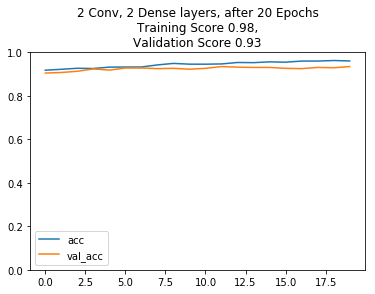

In [238]:
plt.plot(hist2.history['acc'],label='acc')
plt.plot(hist2.history['val_acc'],label='val_acc')
plt.ylim(0,1)
plt.title('2 Conv, 2 Dense layers, after {0} Epochs\nTraining Score {1:1.2f},\n\
Validation Score {2:1.2f}'.format(NrEpochs2,training_score[1],validation_score[1]))
plt.legend();

Zuletzt versuchen wir noch ein fast komplettes AlexNet. Dies mag auf nichtspezialisierter Hardware etwas lange dauern...

In [226]:
from keras.layers import Conv2D,BatchNormalization,ZeroPadding2D
from keras.regularizers import l2
l2_reg = 0.05
n_classes = y_train.shape[1]

alexnet = Sequential()
alexnet.add(Conv2D(96, (11, 11), input_shape=(28,28,1),
    padding='same', kernel_regularizer=l2(l2_reg)))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(512, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(3072))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(n_classes))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))

In [227]:
# 8. Compile model
alexnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [228]:
# 9. Fit model on training data
NrEpochs=20
hist3 = alexnet.fit(X_train, y_train, 
          batch_size=128, epochs=10, validation_data=(X_val, y_val), verbose=1)

Train on 6613 samples, validate on 735 samples
Epoch 1/10
6613/6613 [==============================] - 54s 8ms/step - loss: 0.7888 - acc: 0.8660 - val_loss: 0.5753 - val_acc: 0.8871
Epoch 2/10
6613/6613 [==============================] - 35s 5ms/step - loss: 0.5284 - acc: 0.9344 - val_loss: 0.6327 - val_acc: 0.9102
Epoch 3/10
6613/6613 [==============================] - 35s 5ms/step - loss: 0.4316 - acc: 0.9512 - val_loss: 0.6811 - val_acc: 0.8884
Epoch 4/10
6613/6613 [==============================] - 35s 5ms/step - loss: 0.3739 - acc: 0.9584 - val_loss: 0.5255 - val_acc: 0.9333
Epoch 5/10
6613/6613 [==============================] - 36s 5ms/step - loss: 0.3185 - acc: 0.9710 - val_loss: 0.6043 - val_acc: 0.9197
Epoch 6/10
6613/6613 [==============================] - 36s 5ms/step - loss: 0.2803 - acc: 0.9778 - val_loss: 0.5157 - val_acc: 0.9224
Epoch 7/10
6613/6613 [==============================] - 36s 5ms/step - loss: 0.2471 - acc: 0.9823 - val_loss: 0.5354 - val_acc: 0.9184
Epoch 8/

In [239]:
training_score = alexnet.evaluate(X_train, y_train, verbose=0)
validation_score = alexnet.evaluate(X_val, y_val, verbose=0)

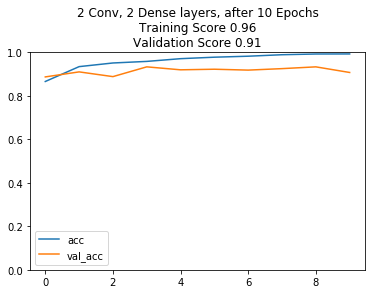

In [240]:
plt.plot(hist3.history['acc'],label='acc')
plt.plot(hist3.history['val_acc'],label='val_acc')
plt.ylim(0,1)
plt.title('2 Conv, 2 Dense layers, after {0} Epochs\nTraining Score {1:1.2f}\n\
Validation Score {2:1.2f}'.format(NrEpochs3,training_score[1],validation_score[1]))
plt.legend();

Aua! Hier ist Overfitting sichtbar: Wir haben zu wenig Daten, um all die Parameter zu fitten. Der Validierungsfehler ist kleiner als beim vorletzten Modell, `model2`. Bei der model selection entscheiden wir uns daher für Modell 2.

Versuchen wir nun, die Ausgabe des neuronalen Netzes zu verstehen:

In [249]:
y_hat_train = model2.predict(X_train)
y_hat_test = model2.predict(X_test)
assert np.any(np.isnan(y_hat_train)) == False, 'Achtung, NaN-Werte sind vorhanden'

In [247]:
#Die Ausgabe ist one-hot:
print(y_hat_train.shape)
#und normiert, wegen dem Softmax-Layer am Schluss:
print(np.sum(y_hat_train[0]))
y_hat_train[0]

(7348, 10)
1.0


array([3.1021794e-15, 9.9706179e-15, 9.9999809e-01, 3.9186774e-13,
       8.6951317e-08, 1.5960460e-11, 1.8591437e-06, 5.2714343e-14,
       1.3427264e-12, 3.4149105e-15], dtype=float32)

Der Softmax-Layer ist deutlich sichtbar daran, dass das folgende Bild v.a. Werte nahe 0 und 1 zeigen, aber wenig dazwischen:

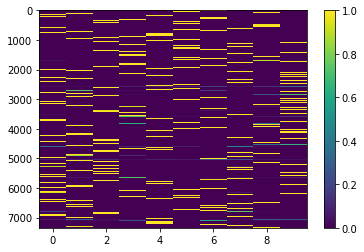

In [265]:
plt.subplot(1,1,1)
plt.imshow(y_hat_train)
ax = plt.gca()
ax.set_aspect('auto')
plt.colorbar();

In [268]:
#Mit einem Argmax bestimmen wir das Label:
y_hat_train_int = pd.Series(np.argmax(y_hat_train,axis=1),name='target')
y_hat_test_int = pd.Series(np.argmax(y_hat_test,axis=1),name='target')

#Das Netzwerk sollte zumindestens jedes Label mal benutzen!
y_hat_train_int.unique()

array([2, 9, 3, 0, 4, 5, 7, 1, 6, 8])

In [270]:
#Nun benötigen wir für die Submission labels 'A' bis 'J':
int_to_label_dict = dict(zip(label_to_int_dict.values(),label_to_int_dict.keys()))
int_to_label_dict

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J'}

In [273]:
y_hat_train_as_letters = y_hat_train_int.map(int_to_label_dict)
y_hat_train_as_letters.unique()

array(['C', 'J', 'D', 'A', 'E', 'F', 'H', 'B', 'G', 'I'], dtype=object)

In [287]:
y_hat_test_as_letters = y_hat_test_int.map(int_to_label_dict)

In [288]:
y_hat_test = pd.Series(y_hat_test_as_letters,name='target')
y_hat_test.index.name = 'Id'

In [291]:
y_hat_test.to_csv('prediction_toedtli.csv',header=True)